In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, hilbert, welch
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Load data

In [3]:
# Load data 

def load_data(train_path, test_path):
    X_train = pd.read_csv(train_path, index_col="id")
    y_train = X_train.iloc[:, 0]
    X_train = X_train.iloc[:, 1:]
    X_test = pd.read_csv(test_path, index_col="id")
    return transform_data(X_train), y_train.values, transform_data(X_test)

def transform_data(df):
    return np.array([row.dropna().to_numpy(dtype='float32') for _, row in df.iterrows()], dtype=object)

X_train_raw, y_train_raw, X_test_raw = load_data(
    train_path = "train.csv",
    test_path = "test.csv"
)
print(
    "X_train_raw shape: ",
    X_train_raw.shape,
    "\ny_train shape",
    y_train_raw.shape,
    "\nX_test shape",
    X_test_raw.shape,
)


X_train_raw shape:  (5117,) 
y_train shape (5117,) 
X_test shape (3411,)


Check the distribution of signal lengths


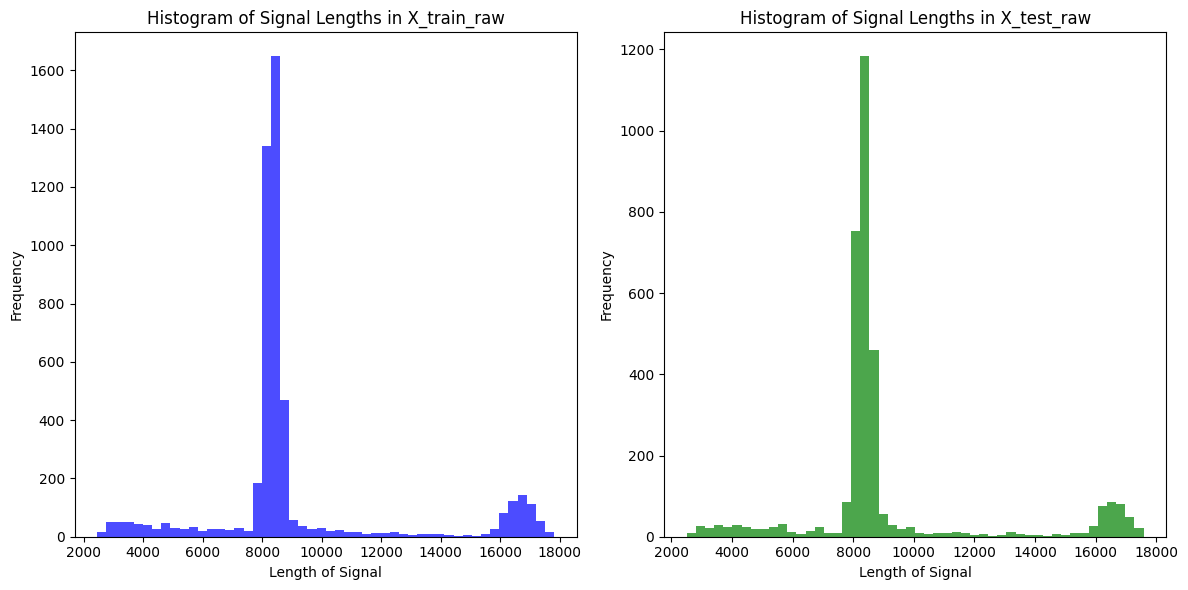

In [4]:

# Calculate the lengths of signals
lengths_train = [len(signal) for signal in X_train_raw]
lengths_test = [len(signal) for signal in X_test_raw]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(lengths_train, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Signal Lengths in X_train_raw')
plt.xlabel('Length of Signal')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(lengths_test, bins=50, color='green', alpha=0.7)
plt.title('Histogram of Signal Lengths in X_test_raw')
plt.xlabel('Length of Signal')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see the signal lengths are concentrated around 8000 and 16000 so we process the training data as such to avoid excessive padding and truncating: 

Signals with fewer than 8000 samples are padded. If a signal has more than 8000 samples, it's broken into as many 8000-sample segments as possible with the remaining samples truncated. For example, a signal with 16500 samples becomes two 8000-sample signals, and the remaining 500 samples are ignored. At the same time, y_train will be updated such that if there's a signal that is broken into more than one 8000 piece, the label is duplicated

In [5]:
def pad_and_truncate_train(signals, labels, target_length=8001):
    """
    Pads signals shorter than the target length, splits longer signals into multiple segments, 
    and updates labels accordingly.

    Args:
    - signals: List of 1D arrays, each representing an ECG signal.
    - labels: List or array of labels corresponding to the signals.
    - target_length: Desired length for each segment.

    Returns:
    - padded_split_signals: List of 1D arrays, each of length target_length.
    - updated_labels: List of labels corresponding to the new segments.
    """
    padded_split_signals = []
    updated_labels = []

    for signal, label in zip(signals, labels):
        if len(signal) < target_length:
            # Pad the signal if it's shorter than the target length
            padded_signal = np.pad(signal, (0, target_length - len(signal)), mode='constant')
            padded_split_signals.append(padded_signal)
            updated_labels.append(label)
        else:
            # Split the signal into multiple segments of target_length
            for i in range(0, len(signal) // target_length):
                segment = signal[i * target_length: (i + 1) * target_length]
                padded_split_signals.append(segment)
                updated_labels.append(label)

    return np.array(padded_split_signals), np.array(updated_labels)

In [6]:
# Process training data
X_train_padded, y_train_updated = pad_and_truncate_train(X_train_raw, y_train_raw, target_length=8001)


print("X_train_padded shape:", X_train_padded.shape)  # Example: (n_segments_train, 8000)
print("y_train_updated shape:", y_train_updated.shape)  # Example: (n_segments_train,)


X_train_padded shape: (5644, 8001)
y_train_updated shape: (5644,)


For the test data we only pad or truncate to 8000 without breaking up signals

In [7]:
def pad_or_truncate_test(signals, target_length=8001):
    """
    Pads or truncates signals to a fixed target length.

    Args:
    - signals: List of 1D arrays, each representing an ECG signal.
    - target_length: Desired length for each signal.

    Returns:
    - processed_signals: List of 1D arrays, each of length target_length.
    """
    processed_signals = []
    for signal in signals:
        if len(signal) < target_length:
            # Pad the signal if it's shorter than the target length
            processed_signal = np.pad(signal, (0, target_length - len(signal)), mode='constant')
        else:
            # Truncate the signal if it's longer than the target length
            processed_signal = signal[:target_length]
        processed_signals.append(processed_signal)
    
    return np.array(processed_signals)


In [8]:
# Process test data (pad or truncate only)
X_test_padded = pad_or_truncate_test(X_test_raw, target_length=8001)

print("X_test_padded shape:", X_test_padded.shape)  # Example: (n_signals_test, 8000)


X_test_padded shape: (3411, 8001)


Check the number of different labels

In [9]:
unique, counts = np.unique(y_train_updated, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3285, 1: 499, 2: 1685, 3: 175}


The classes are imbalanced so we need to add class weights to the model later

In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Class labels
class_labels = np.unique(y_train_updated)  # Assuming one-hot encoded y_train_updated

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train_updated  # Convert one-hot to class indices
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 0.42952815829528157, 1: 2.8276553106212425, 2: 0.8373887240356083, 3: 8.062857142857142}


## Preprocessing

In [11]:
def extract_instantaneous_frequency(signal, sampling_rate=300):
    """
    Extract instantaneous frequency using the Hilbert transform.
    
    Args:
    - signal: 1D ECG signal.
    - sampling_rate: Sampling rate of the ECG signal in Hz.

    Returns:
    - instantaneous_frequency: 1D array of instantaneous frequency.
    """
    analytic_signal = hilbert(signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) * (sampling_rate / (2.0 * np.pi))
    return instantaneous_frequency

# Example usage
insta_freq_train = [extract_instantaneous_frequency(signal) for signal in X_train_padded]
insta_freq_test = [extract_instantaneous_frequency(signal) for signal in X_test_padded]

print("The shape of the extracted instantaneous frequency for the training set is: ", np.array(insta_freq_train).shape,
      "\nThe shape of the extracted instantaneous frequency for the test set is: ", np.array(insta_freq_test).shape)

The shape of the extracted instantaneous frequency for the training set is:  (5644, 8000) 
The shape of the extracted instantaneous frequency for the test set is:  (3411, 8000)


In [12]:
def spectral_entropy(signal, sampling_rate=300):
    """
    Calculate spectral entropy of a signal.
    
    Args:
    - signal: 1D ECG signal.
    - sampling_rate: Sampling rate of the ECG signal in Hz.

    Returns:
    - entropy: Spectral entropy of the signal.
    """
    freqs, psd = welch(signal, fs=sampling_rate)
    psd_norm = psd / np.sum(psd)  # Normalize the power spectral density
    entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))  # Add eps to avoid log(0)
    return entropy

# Example usage
spec_entro_train = [spectral_entropy(signal) for signal in X_train_padded]
spec_entro_test = [spectral_entropy(signal) for signal in X_test_padded]

In [13]:
def combine_features(instantaneous_frequencies, spectral_entropies):
    """
    Combine instantaneous frequency and spectral entropy features for each signal.
    
    Args:
    - instantaneous_frequencies: List of 1D arrays of instantaneous frequencies.
    - spectral_entropies: List of spectral entropy values.

    Returns:
    - combined_features: 3D array of combined features (n_samples, time_steps, 2).
    """
    combined_features = []
    for freq, entropy in zip(instantaneous_frequencies, spectral_entropies):
        # Match the length of instantaneous frequency
        entropy_replicated = np.full_like(freq, entropy)
        combined_signal_features = np.stack([freq, entropy_replicated], axis=-1)
        combined_features.append(combined_signal_features)
    return np.array(combined_features)

# Combine features for training and test data
X_train_combined = combine_features(insta_freq_train, spec_entro_train)
X_test_combined = combine_features(insta_freq_test, spec_entro_test)

print("X_train_combined shape:", X_train_combined.shape)  
print("X_test_combined shape:", X_test_combined.shape)


X_train_combined shape: (5644, 8000, 2)
X_test_combined shape: (3411, 8000, 2)


Turns out that a sequence length of 7999 exceeds the GPU memory so we break the signals up into windows of size 300

In [18]:
def split_2d_signal_with_labels(signals, labels, window_size=400, step_size=400):
    """
    Split 2D signals into windows and duplicate labels for training data.

    Args:
    - signals: List of 2D arrays (time_steps, features) representing signals.
    - labels: Array of labels for the signals.
    - window_size: Length of each window (number of time steps).
    - step_size: Step size between consecutive windows.

    Returns:
    - windows: Array of shape (n_windows, window_size, features).
    - new_labels: Array of labels corresponding to the windows.
    """
    windows = []
    new_labels = []

    for signal, label in zip(signals, labels):
        for start in range(0, len(signal) - window_size + 1, step_size):
            window = signal[start:start + window_size, :]
            windows.append(window)
            new_labels.append(label)  # Duplicate the label for each window

    return np.array(windows), np.array(new_labels)

# Apply to training data

X_train_split, y_train_split = split_2d_signal_with_labels(
    X_train_combined, y_train_updated, window_size=400, step_size=400
)

print("X_train_split shape:", X_train_split.shape)  # Example: (n_train_segments, 400, 2)
print("y_train_split shape:", y_train_split.shape)  # Example: (n_train_segments, 4)

def split_2d_signal_with_mapping(signal, window_size=1000, step_size=1000):
    """
    Split a 2D signal (time steps × features) into smaller windows with mapping to the original signal.

    Args:
    - signal: 2D array with shape (time_steps, features).
    - window_size: Length of each window (number of time steps).
    - step_size: Step size between consecutive windows.

    Returns:
    - windows: Array of shape (n_windows, window_size, features).
    - mappings: List indicating the original signal index for each window.
    """
    windows = []
    mappings = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        window = signal[start:start + window_size, :]
        windows.append(window)
        mappings.append(len(windows) - 1)  # Map window to index
    return np.array(windows), mappings

# Apply to test data

# Split test data into windows and track mappings
X_test_split = []
segment_mappings = []

for i, signal in enumerate(X_test_combined):
    windows, mappings = split_2d_signal_with_mapping(signal, window_size=400, step_size=400)
    X_test_split.extend(windows)
    segment_mappings.extend([i] * len(windows))  # Map each window to its signal index

X_test_split = np.array(X_test_split)
segment_mappings = np.array(segment_mappings)

print("X_test_split shape:", X_test_split.shape)  # Example: (n_test_segments, 400, 2)
print("Segment mappings shape:", segment_mappings.shape)  # Example: (n_test_segments,)



X_train_split shape: (112880, 400, 2)
y_train_split shape: (112880,)
X_test_split shape: (68220, 400, 2)
Segment mappings shape: (68220,)


In [19]:
# One-hot encode the labels

from tensorflow.keras.utils import to_categorical

# One-hot encode y_train_split
y_train_split_one_hot = to_categorical(y_train_split, num_classes=4)

print("y_train_split_one_hot shape:", y_train_split_one_hot.shape)  # Example: (n_train_segments, 4)


y_train_split_one_hot shape: (112880, 4)


## Build model

In [25]:
# Define the BiLSTM model
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, input_shape=(X_train_split.shape))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(X_train_split.shape))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (112880, 400, 100)       21200     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (112880, 400, 100)        0         
                                                                 
 bidirectional_6 (Bidirectio  (112880, 128)            84480     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (112880, 128)             0         
                                                                 
 dense_6 (Dense)             (112880, 64)              8256      
                                                                 
 dropout_10 (Dropout)        (112880, 64)             

In [26]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_split, y_train_split_one_hot,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weights,  # Handle imbalance
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

model.save("lstm.h5")

Epoch 1/50
131/353 [==========>...................] - ETA: 33s - loss: 1.2890 - accuracy: 0.2827

KeyboardInterrupt: 